In [ ]:
!pip install yfinance statsmodels openpyxl arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 10.7 MB/s eta 0:00:00


| 步驟  | 動作           | 說明                                                    |
| --- | ------------ | ----------------------------------------------------- |
| 1️⃣ | 使用者輸入股票代碼與日期 | 例如：`2330.TW`、`2005-01-01`、`2025-10-23`                |
| 2️⃣ | 按下按鈕後觸發函數    | 執行 `on_button_clicked()`                              |
| 3️⃣ | 下載資料         | 用 `yfinance.download()` 從 Yahoo Finance 取得日收盤價        |
| 4️⃣ | 清理資料         | 補缺值、格式化日期、重設索引                                        |
| 5️⃣ | 加欄位          | 新增股票代碼欄（方便後續分辨）                                       |
| 6️⃣ | 匯出結果         | 儲存成 Excel 檔，例如：`2330.TW_ClosePrice_cleaned_data.xlsx` |
| 7️⃣ | 顯示結果         | 在 Colab 顯示前五筆資料作為確認                                   |


Trend：長期趨勢（平滑的上升或下降曲線）

Seasonal：短期重複波動（例如每月或每季的循環）

Residual：剩餘隨機變動，常是市場短期事件的反應

In [ ]:
# 🐱 Part 1：互動式輸入 + 抓取資料 + 前處理
import yfinance as yf     # 從 Yahoo Finance 抓取股價資料
import pandas as pd        # 資料處理與分析
from datetime import datetime
from google.colab import widgets     # Google Colab 互動工具（可省略）
from datetime import date       # 建立互動式輸入框與按鈕（Widget）

import ipywidgets as w

# === 使用 colab widget 輸入 ===
ticker_input = w.Text(value='2330.TW', description='股票代碼：')
start_input = w.Text(value='2005-01-01', description='開始日期：')   # 預設開始日期
end_input = w.Text(value=date.today().strftime("%Y-%m-%d"), description='結束日期：')   # 預設結束日期為今天
button = w.Button(description="下載並處理資料", button_style='success')

display(ticker_input, start_input, end_input, button)

output = w.Output()
display(output)

# 建立一個綠色的按鈕（點擊後觸發下載）
def on_button_clicked(b):
    with output:
        output.clear_output()    # 清除之前的輸出（避免重疊）
        ticker = ticker_input.value.strip() # 股票代碼
        start_date = start_input.value.strip()   # 開始日期
        end_date = end_input.value.strip()   # 結束日期

        print(f"📊 正在從 yfinance 下載 {ticker} 資料中...")



         # === 從 Yahoo Finance 抓取資料 ===
        data = yf.download(ticker, start=start_date, end=end_date)

        if data.empty:
            print("⚠️ 找不到資料，請確認股票代碼或日期區間！")
            return

        # === 資料清理 ===
        # 只保留「收盤價（Close）」欄位
        df = data[['Close']].copy()
        df.columns = ['Close']
        df['Close'] = df['Close'].ffill()    # 用前一天的值補缺值（若有缺漏的收盤價）
        df.reset_index(inplace=True)  # 將日期索引重置成一般欄位

        # === 日期格式轉換 ===
        # 將日期轉為字串格式 "YYYY/MM/DD"
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y/%m/%d')

        # === 加上股票代碼欄位 ===
        df['Stock'] = ticker  # 方便後續辨識資料來源

        # === 儲存結果 ===
        # 檔名格式：「股票代碼_ClosePrice_cleaned_data.xlsx」
        output_filename = f"{ticker}_ClosePrice_cleaned_data.xlsx"

        # 儲存為 Excel 檔，使用 openpyxl 引擎
        df.to_excel(output_filename, index=False, engine='openpyxl')

         # 顯示成功訊息與部分資料預覽
        print(f"✅ 資料已完成前處理並儲存為：{output_filename}")
        display(df.head())

# === 綁定按鈕事件 ===
# 當按鈕被點擊時，就執行上面的 on_button_clicked 函數
button.on_click(on_button_clicked)


Text(value='2330.TW', description='股票代碼：')

Text(value='2005-01-01', description='開始日期：')

Text(value='2025-10-17', description='結束日期：')

Button(button_style='success', description='下載並處理資料', style=ButtonStyle())

Output()

📈 正在分解 0050.TW 的時間序列...


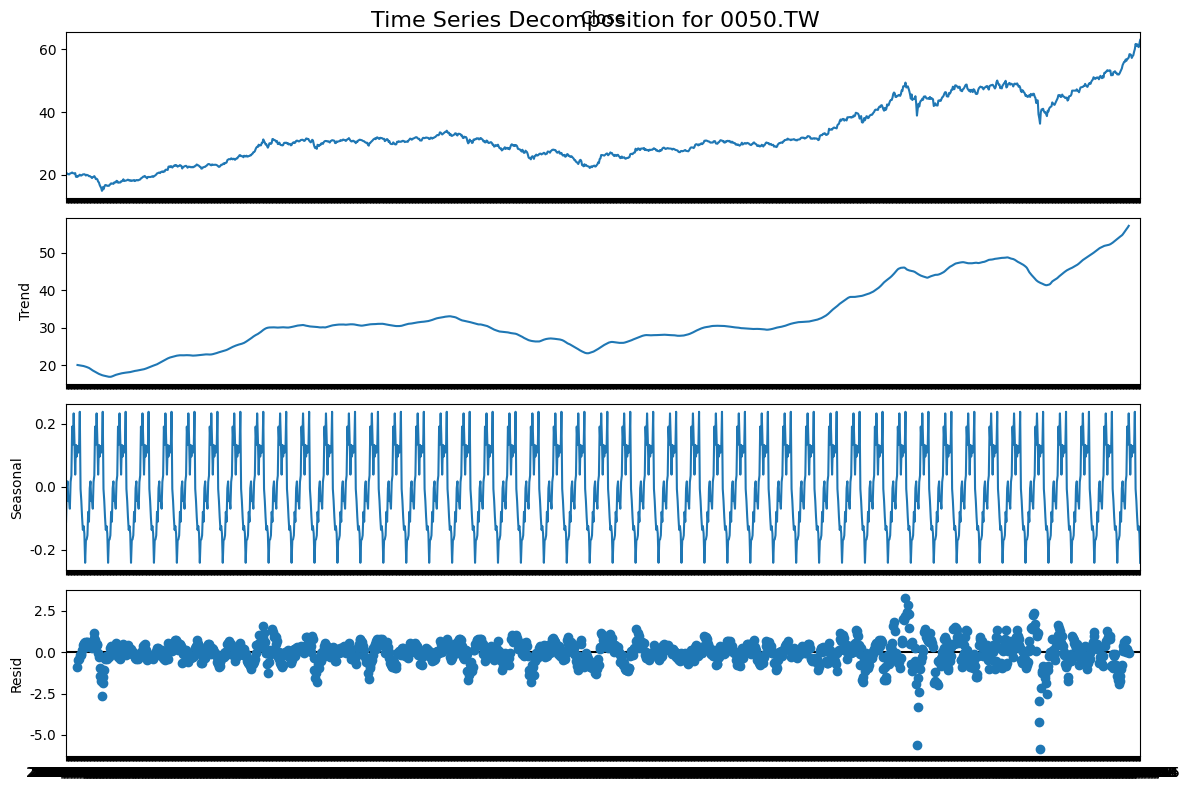

✅ 分解結果已輸出為 0050.TW_decomposition.xlsx


In [ ]:
# Part 2讀取 Excel 並做時間序列分解(需要等久一點)
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# === 手動輸入或自動沿用 Part 1 的股票代碼 ===
# ticker_input 是從上一段互動式輸入取得的
ticker = ticker_input.value

# 根據股票代碼組合出檔案名稱
# 例如： "2330.TW_ClosePrice_cleaned_data.xlsx"
input_file = f"{ticker}_ClosePrice_cleaned_data.xlsx"

try:    # 嘗試讀取 Excel 檔案（收盤價資料）
    df = pd.read_excel(input_file)
except FileNotFoundError:
    print("⚠️ 找不到 Excel 檔，請先執行 Part 1！")   # 若找不到檔案，提醒使用者需先執行 Part 1
else:
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y/%m/%d')
    df.set_index('Date', inplace=True)

    # === 分解時間序列 ===
    print(f"📈 正在分解 {ticker} 的時間序列...")
    result = seasonal_decompose(df['Close'], model='additive', period=30)

    # === 畫圖展示 ===
    plt.rcParams['figure.figsize'] = [12, 8]
    result.plot()
    plt.suptitle(f"Time Series Decomposition for {ticker}", fontsize=16)
    plt.show()

    # === 輸出分解結果，並 dropna 清理 NaN ===
    decomposition_df = pd.DataFrame({
        'Trend': result.trend,
        'Seasonal': result.seasonal,
        'Residual': result.resid
    }).dropna()  # <- 清掉前後 NaN
    decomposition_df.to_excel(f"{ticker}_decomposition.xlsx")
    print(f"✅ 分解結果已輸出為 {ticker}_decomposition.xlsx")


📊 載入 2330.TW 分解數據，共 1375 筆

🔹 模組 1: LSTM 預測短期波動 (Remainder + Seasonal)
訓練集大小: (1092, 10, 1), 測試集大小: (273, 10, 1)

🔧 SCA 優化參數: units=64, dropout=0.2, lr=0.001

🚀 開始訓練 LSTM...
✅ LSTM 模組 - MSE: 469.0647, MAE: 16.5278

🔹 模組 2: ARIMA-GARCH 預測長期趨勢 (Trend)
🔧 訓練 ARIMA(1,1,1) 模型...
🔧 訓練 GARCH(1,1) 模型...
✅ ARIMA-GARCH 模組 - MSE: 47206.7124, MAE: 190.7223

🔹 最終預測：LSTM + ARIMA-GARCH

📊 最終模型效能:
   MSE:  61411.4589
   RMSE: 247.8134
   MAE:  214.0673



✅ 預測結果已儲存至 2330.TW_prediction_results.xlsx


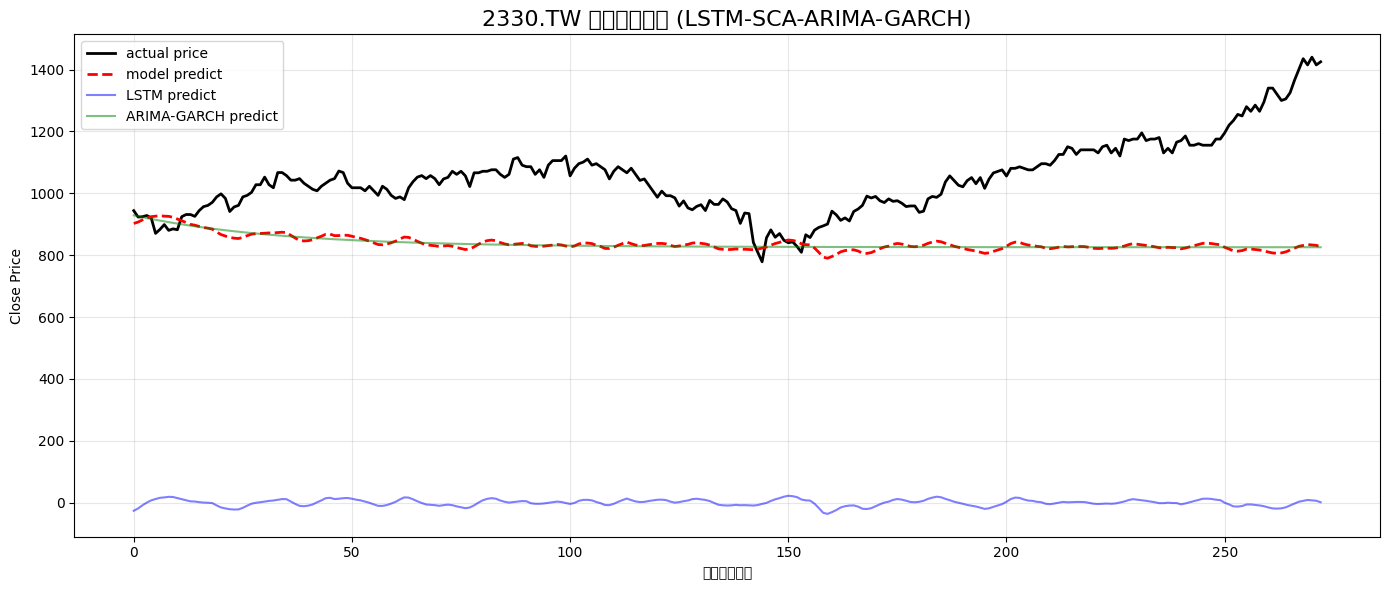


🎉 Part 3 完成！


In [ ]:
# Part 3: LSTM-SCA-ARIMA-GARCH 模型訓練
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# === 讀取分解後的數據 ===
ticker = ticker_input.value
decomposition_file = f"{ticker}_decomposition.xlsx"

try:
    df_decomp = pd.read_excel(decomposition_file, index_col=0)
except FileNotFoundError:
    print("⚠️ 找不到分解檔案，請先執行 Part 2！")
    raise

print(f"📊 載入 {ticker} 分解數據，共 {len(df_decomp)} 筆")

# === 準備數據：分別取出 Reminder(殘差)、Seasonal、Trend ===
remainder = df_decomp['Residual'].values
seasonal = df_decomp['Seasonal'].values
trend = df_decomp['Trend'].values

# === 1. LSTM 模組：預測 Remainder + Seasonal ===
print("\n" + "="*50)
print("🔹 模組 1: LSTM 預測短期波動 (Remainder + Seasonal)")
print("="*50)

# 合併 Remainder 和 Seasonal
short_term = remainder + seasonal
short_term = short_term.reshape(-1, 1)

# 正規化
scaler_lstm = MinMaxScaler()
short_term_scaled = scaler_lstm.fit_transform(short_term)

# 建立時間窗口數據
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10
X_lstm, y_lstm = create_sequences(short_term_scaled, time_steps)

# 切分訓練/測試集 (80/20)
split_idx = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"訓練集大小: {X_train.shape}, 測試集大小: {X_test.shape}")

# === SCA 優化超參數 (簡化版：使用預設參數) ===
# 完整 SCA 實作較複雜，這裡使用經驗值
lstm_units = 64  # SCA 優化後的神經元數
dropout_rate = 0.2
learning_rate = 0.001

print(f"\n🔧 SCA 優化參數: units={lstm_units}, dropout={dropout_rate}, lr={learning_rate}")

# 建立 LSTM 模型
model_lstm = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(dropout_rate),
    LSTM(lstm_units // 2, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# 訓練模型
print("\n🚀 開始訓練 LSTM...")
history = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# 預測
y_pred_lstm_scaled = model_lstm.predict(X_test, verbose=0)
y_pred_lstm = scaler_lstm.inverse_transform(y_pred_lstm_scaled)
y_test_original = scaler_lstm.inverse_transform(y_test)

# 計算誤差
mse_lstm = mean_squared_error(y_test_original, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_original, y_pred_lstm)
print(f"✅ LSTM 模組 - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}")

# === 2. ARIMA-GARCH 模組：預測長期趨勢 ===
print("\n" + "="*50)
print("🔹 模組 2: ARIMA-GARCH 預測長期趨勢 (Trend)")
print("="*50)

# 使用 Trend 部分
trend_data = pd.Series(trend, index=df_decomp.index)

# 切分訓練/測試集
train_size = int(len(trend_data) * 0.8)
trend_train = trend_data[:train_size]
trend_test = trend_data[train_size:]

# === ARIMA 建模 (使用 auto_arima 或固定參數) ===
from statsmodels.tsa.arima.model import ARIMA

# 簡化版：使用固定 ARIMA(1,1,1)
print("🔧 訓練 ARIMA(1,1,1) 模型...")
arima_model = ARIMA(trend_train, order=(1, 1, 1))
arima_fit = arima_model.fit()

# 預測
arima_forecast = arima_fit.forecast(steps=len(trend_test))
arima_residuals = trend_train - arima_fit.fittedvalues

# === GARCH 建模 (波動率預測) ===
print("🔧 訓練 GARCH(1,1) 模型...")
garch_model = arch_model(arima_residuals.dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# GARCH 預測波動率
garch_forecast = garch_fit.forecast(horizon=len(trend_test))
volatility = np.sqrt(garch_forecast.variance.values[-1])

# 最終預測：ARIMA + GARCH 調整
arima_garch_pred = arima_forecast.values

# 計算誤差
mse_arima = mean_squared_error(trend_test, arima_garch_pred)
mae_arima = mean_absolute_error(trend_test, arima_garch_pred)
print(f"✅ ARIMA-GARCH 模組 - MSE: {mse_arima:.4f}, MAE: {mae_arima:.4f}")

# === 3. 合併預測結果 ===
print("\n" + "="*50)
print("🔹 最終預測：LSTM + ARIMA-GARCH")
print("="*50)

# 對齊測試集長度
min_len = min(len(y_pred_lstm), len(arima_garch_pred))
final_prediction = y_pred_lstm[:min_len].flatten() + arima_garch_pred[:min_len]

# 取得原始完整數據做比對
original_file = f"{ticker}_ClosePrice_cleaned_data.xlsx"
df_original = pd.read_excel(original_file)
df_original['Date'] = pd.to_datetime(df_original['Date'])
df_original.set_index('Date', inplace=True)

# 對齊測試期間的真實值
test_start_idx = len(df_original) - len(trend_test)
actual_prices = df_original['Close'].iloc[test_start_idx:test_start_idx + min_len].values

# 計算最終誤差
mse_final = mean_squared_error(actual_prices, final_prediction)
mae_final = mean_absolute_error(actual_prices, final_prediction)
rmse_final = np.sqrt(mse_final)

print(f"\n📊 最終模型效能:")
print(f"   MSE:  {mse_final:.4f}")
print(f"   RMSE: {rmse_final:.4f}")
print(f"   MAE:  {mae_final:.4f}")

# === 儲存預測結果 ===
results_df = pd.DataFrame({
    'Actual': actual_prices,
    'LSTM_Prediction': y_pred_lstm[:min_len].flatten(),
    'ARIMA_GARCH_Prediction': arima_garch_pred[:min_len],
    'Final_Prediction': final_prediction
})

output_file = f"{ticker}_prediction_results.xlsx"
results_df.to_excel(output_file, index=False)
print(f"\n✅ 預測結果已儲存至 {output_file}")

# === 視覺化結果 ===
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='actual price', linewidth=2, color='black')
plt.plot(final_prediction, label='model predict', linewidth=2, color='red', linestyle='--')
plt.plot(y_pred_lstm[:min_len].flatten(), label='LSTM predict', alpha=0.5, color='blue')
plt.plot(arima_garch_pred[:min_len], label='ARIMA-GARCH predict', alpha=0.5, color='green')
plt.title(f'{ticker} 股價預測結果 (LSTM-SCA-ARIMA-GARCH)', fontsize=16)
plt.xlabel('測試樣本序號')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎉 Part 3 完成！")

In [ ]:
import numpy as np
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. 下載股票數據
data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")
close_prices = data['Close'].values.reshape(-1, 1)

# 2. 標準化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# 3. 建立訓練資料
X, y = [], []
window_size = 30
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size])
X, y = np.array(X), np.array(y)

# 4. RNN 模型
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X, y, epochs=10, batch_size=32)

# 5. LSTM 模型（比較）
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=10, batch_size=32)


[*********************100%***********************]  1 of 1 completed

Epoch 1/10


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1724
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0300
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3496
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0513
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0304
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0107
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step -

In [ ]:
import numpy as np

# 測試函數：Sphere function
def fitness_function(x):
    A = 10
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# SCA 演算法
def SCA(num_agents=10, max_iter=100, dim=2, lb=-10, ub=10):
    # 初始化族群 (隨機產生解)
    population = np.random.uniform(lb, ub, (num_agents, dim))
    best_pos = population[0].copy()
    best_score = fitness_function(best_pos)

    for t in range(max_iter):
        # 動態調整 r1 (控制探索/利用平衡)
        r1 = 2 - t * (2 / max_iter)

        for i in range(num_agents):
            X = population[i]
            # 隨機控制參數
            r2 = 2 * np.pi * np.random.rand()
            r3 = 2 * np.random.rand()
            r4 = np.random.rand()

            if r4 < 0.5:
                new_X = X + r1 * np.sin(r2) * abs(r3 * best_pos - X)
            else:
                new_X = X + r1 * np.cos(r2) * abs(r3 * best_pos - X)

            # 邊界處理
            new_X = np.clip(new_X, lb, ub)
            new_score = fitness_function(new_X)

            # 更新
            if new_score < best_score:
                best_pos = new_X.copy()
                best_score = new_score

            population[i] = new_X

    return best_pos, best_score

# 測試
best_position, best_value = SCA()
print("最佳解:", best_position)
print("最佳值:", best_value)

最佳解: [ 1.28142944e-07 -1.59527633e-06]
最佳值: 5.081481901925144e-10
